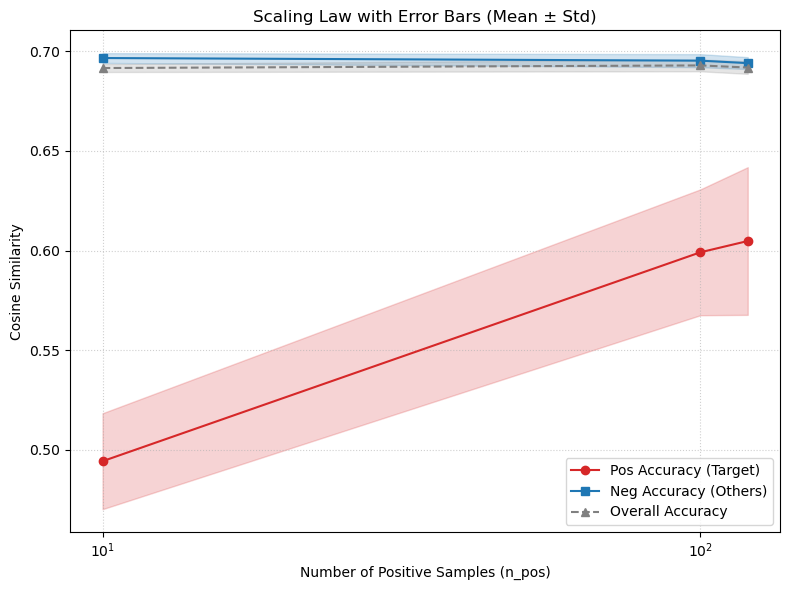

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

FLAG_COLUMN = "has_F"
TRAIN_MODE = "vanilla"  # "vanilla" or "class_balanced_loss"
VAL_METRIC = "val_loss"  # {"val_loss", "val_pos_loss"}

# 1. データの読み込み
df = pd.read_csv(f"output/csv/{FLAG_COLUMN}-{TRAIN_MODE}-esmetric={VAL_METRIC}-ae-v2.csv") 
# ※ここでは提示されたデータ形式と同じ構造を持つDataFrameがあると仮定します

# 2. 集計 (seedごとの平均と標準偏差を算出)
grouped = df.groupby("n_pos_req").agg({
    "pos_acc": ["mean", "std"],
    "neg_acc": ["mean", "std"],
    "overall_acc": ["mean", "std"]
}).reset_index()

# カラム名の整理 (pos_acc_mean, pos_acc_std ... という名前にする)
grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped.columns.values]

# 3. プロット
plt.figure(figsize=(8, 6))

x = grouped["n_pos_req"]

# --- Pos Accuracy (赤色) ---
mean = grouped["pos_acc_mean"]
std = grouped["pos_acc_std"]
plt.plot(x, mean, marker='o', color='tab:red', label='Pos Accuracy (Target)')
# ★ここで fill_between を使用
plt.fill_between(x, mean - std, mean + std, color='tab:red', alpha=0.2)

# --- Neg Accuracy (青色) ---
mean = grouped["neg_acc_mean"]
std = grouped["neg_acc_std"]
plt.plot(x, mean, marker='s', color='tab:blue', label='Neg Accuracy (Others)')
plt.fill_between(x, mean - std, mean + std, color='tab:blue', alpha=0.2)

# --- Overall Accuracy (灰色) ---
mean = grouped["overall_acc_mean"]
std = grouped["overall_acc_std"]
plt.plot(x, mean, marker='^', linestyle='--', color='gray', label='Overall Accuracy')
plt.fill_between(x, mean - std, mean + std, color='gray', alpha=0.2)

# 装飾
plt.xlabel('Number of Positive Samples (n_pos)')
plt.ylabel('Cosine Similarity')
plt.title('Scaling Law with Error Bars (Mean ± Std)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xscale('symlog', linthresh=1)
# plt.ylim(0.41, 0.77)
plt.legend()

plt.tight_layout()
# plt.savefig(f"tmp/{FLAG_COLUMN}-{TRAIN_MODE}-esmetric={VAL_METRIC}-ae.png", dpi=300)
plt.show()

   n_train  n_val  n_test  seed   pos_acc   neg_acc  overall_acc  best_epoch
0      500    500    1000     0  0.404159  0.473555     0.471473           3
1      500    500    1000     1  0.324878  0.484141     0.481115           3
2      500    500    1000     2  0.475536  0.469184     0.469374           3
3      500    500    1000     3  0.323553  0.488091     0.484636           3
4      500    500    1000     4  0.402107  0.485547     0.483628           3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   n_train      25 non-null     int64  
 1   n_val        25 non-null     int64  
 2   n_test       25 non-null     int64  
 3   seed         25 non-null     int64  
 4   pos_acc      25 non-null     float64
 5   neg_acc      25 non-null     float64
 6   overall_acc  25 non-null     float64
 7   best_epoch   25 non-null     int64  
dtypes: float64(

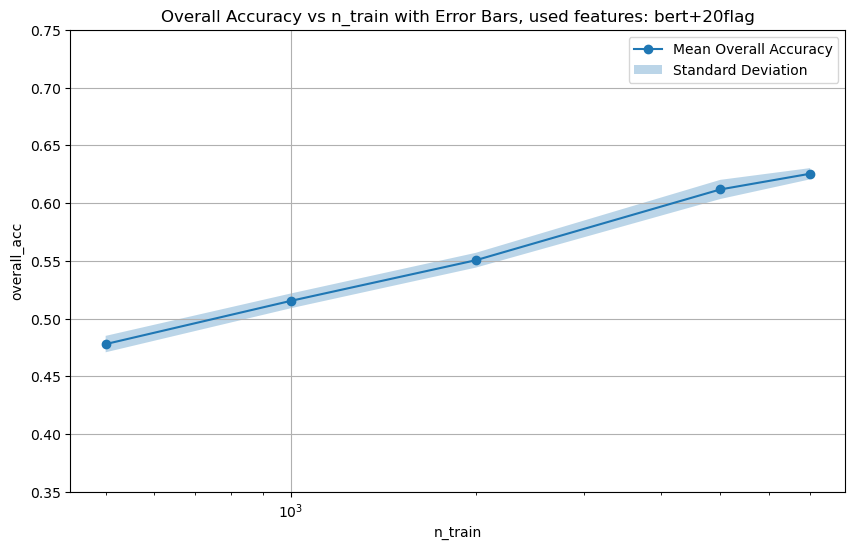

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

suffix = 'bert+20flag'  # 'ae' or 'bert'

# Load the dataframe.
df_has_F_vanilla_scaling = pd.read_csv(f'tmp/scaling/scaling-has_F-{suffix}.csv')

# Print some info.
print(df_has_F_vanilla_scaling.head())
print(df_has_F_vanilla_scaling.info())

# Group by n_train and calculate mean and std for overall_acc
grouped = df_has_F_vanilla_scaling.groupby('n_train')['overall_acc'].agg(['mean', 'std']).reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grouped['n_train'], grouped['mean'], label='Mean Overall Accuracy', marker='o')
plt.fill_between(grouped['n_train'], 
                 grouped['mean'] - grouped['std'], 
                 grouped['mean'] + grouped['std'], 
                 alpha=0.3, label='Standard Deviation')

plt.xlabel('n_train')
plt.ylabel('overall_acc')
plt.xscale('log')
plt.ylim(0.35, 0.75)
plt.title('Overall Accuracy vs n_train with Error Bars, used features: ' + suffix)
plt.legend()
plt.grid(True)

# Save the plot
# plt.savefig(f'tmp/png/overall_scaling-{suffix}.png')

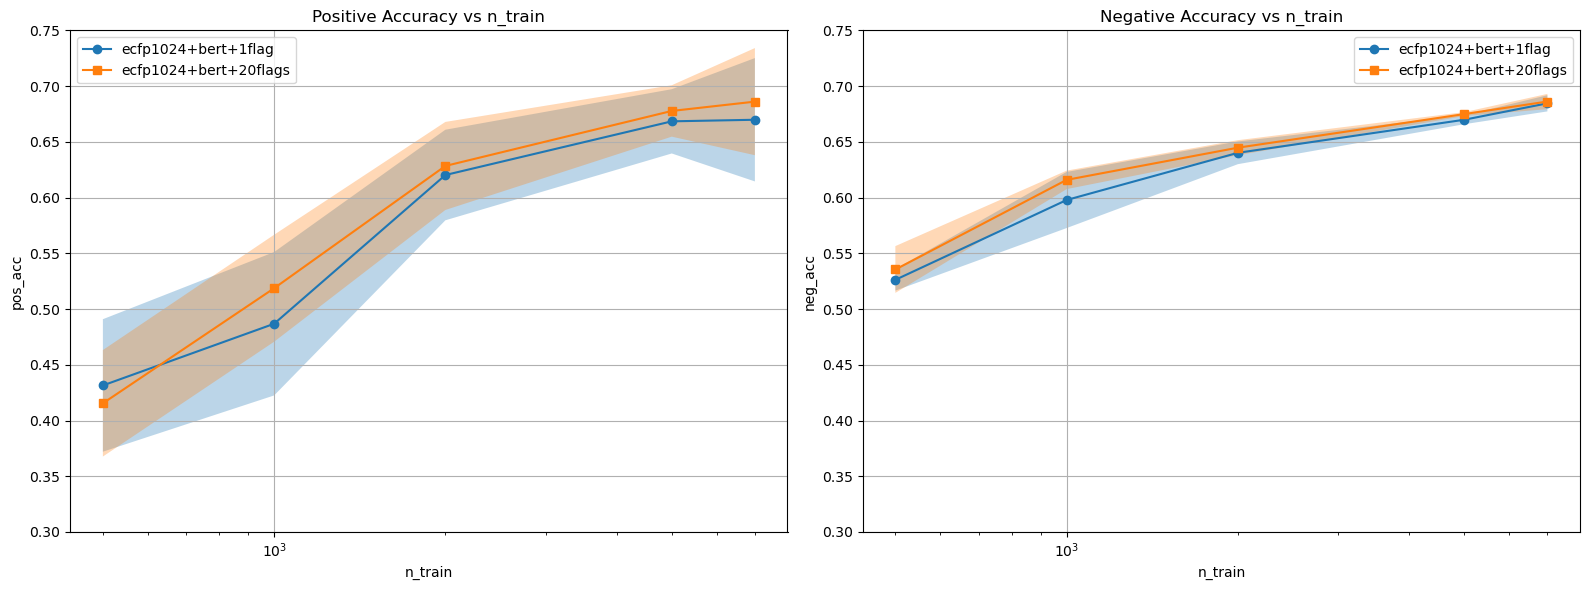

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

first_feature = 'ecfp1024+bert+1flag'
second_feature = 'ecfp1024+bert+20flags'

# Load the dataframes
df_ecfp = pd.read_csv(f'tmp/scaling/scaling-has_F-{first_feature}.csv')
df_multi = pd.read_csv(f'tmp/scaling/scaling-has_F-{second_feature}.csv')

# Aggregation function
def aggregate_data(df, metric):
    return df.groupby('n_train')[metric].agg(['mean', 'std']).reset_index()

# Prepare data for pos_acc
first_pos = aggregate_data(df_ecfp, 'pos_acc')
second_pos = aggregate_data(df_multi, 'pos_acc')

# Prepare data for neg_acc
first_neg = aggregate_data(df_ecfp, 'neg_acc')
second_neg = aggregate_data(df_multi, 'neg_acc')
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot pos_acc
ax = axes[0]
ax.plot(first_pos['n_train'], first_pos['mean'], label=first_feature, marker='o')
ax.fill_between(first_pos['n_train'], 
                first_pos['mean'] - first_pos['std'], 
                first_pos['mean'] + first_pos['std'], 
                alpha=0.3)

ax.plot(second_pos['n_train'], second_pos['mean'], label=second_feature, marker='s')
ax.fill_between(second_pos['n_train'], 
                second_pos['mean'] - second_pos['std'], 
                second_pos['mean'] + second_pos['std'], 
                alpha=0.3)

ax.set_xlabel('n_train')
ax.set_ylabel('pos_acc')
ax.set_title('Positive Accuracy vs n_train')
ax.legend()
ax.grid(True)
ax.set_ylim(0.30, 0.75)
ax.set_xscale('log')

# Plot neg_acc
ax = axes[1]
ax.plot(first_neg['n_train'], first_neg['mean'], label=first_feature, marker='o')
ax.fill_between(first_neg['n_train'], 
                first_neg['mean'] - first_neg['std'], 
                first_neg['mean'] + first_neg['std'], 
                alpha=0.3)

ax.plot(second_neg['n_train'], second_neg['mean'], label=second_feature, marker='s')
ax.fill_between(second_neg['n_train'], 
                second_neg['mean'] - second_neg['std'], 
                second_neg['mean'] + second_neg['std'], 
                alpha=0.3)

ax.set_xlabel('n_train')
ax.set_ylabel('neg_acc')
ax.set_title('Negative Accuracy vs n_train')
ax.legend()
ax.grid(True)
ax.set_ylim(0.30, 0.75)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig(f'tmp/png/comparison_scaling_{first_feature}_vs_{second_feature}.png', dpi=300)


['ecfp1024+bert+20flags', 'ecfp1024+bert', 'ecfp1024+20flags', 'ecfp1024', 'bert+20flags', 'bert']


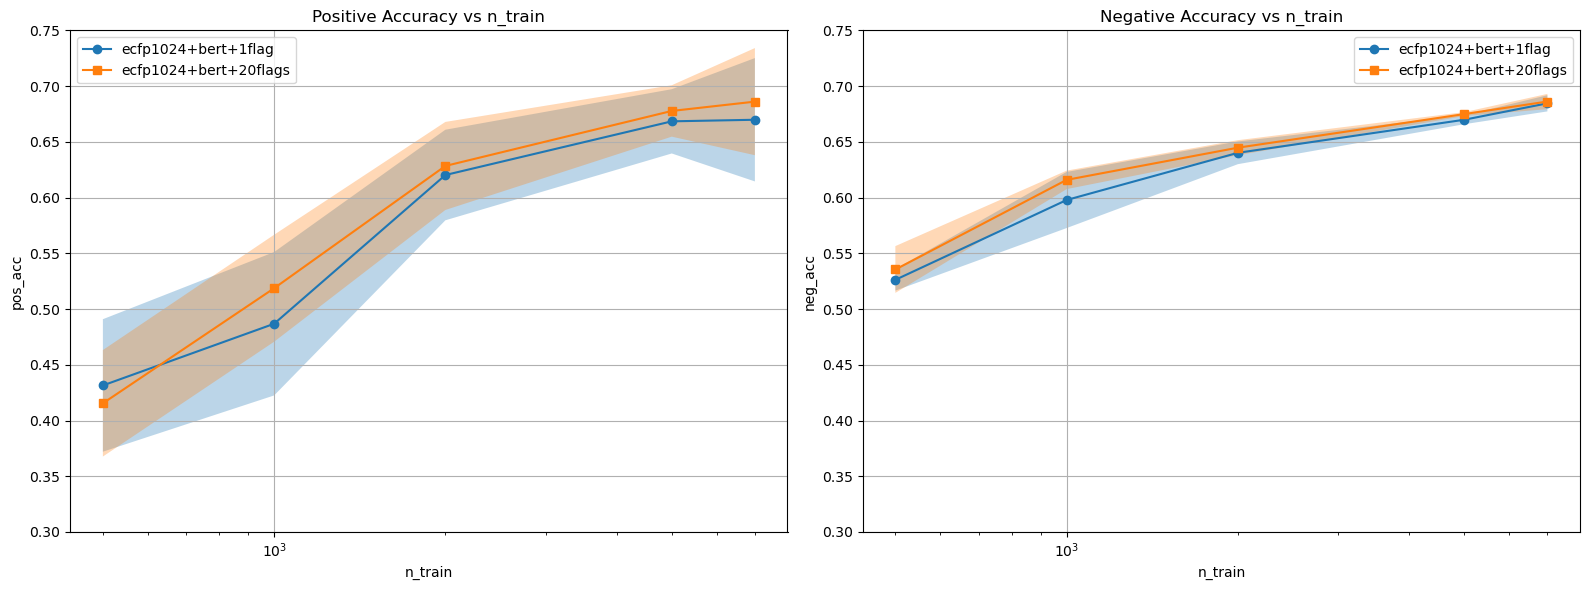

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

first_features = ['ecfp1024', None]
second_features = ['bert', None]
third_features = ['20flags', None]

suffixes = []
for f1 in first_features:
    for f2 in second_features:
        for f3 in third_features:
            parts = [part for part in [f1, f2, f3] if part is not None]
            joined = '+'.join(parts)
            if joined != '' and joined != '20flags':  # Exclude the case where
                suffixes.append('+'.join(parts))

print(suffixes)

# # Load the dataframes
for suffix in suffixes:
    df_{suffix} = pd.read_csv(f'tmp/scaling/scaling-has_F-{suffix}.csv')

# Aggregation function
def aggregate_data(df, metric):
    return df.groupby('n_train')[metric].agg(['mean', 'std']).reset_index()

# Prepare data for pos_acc
first_pos = aggregate_data(df_ecfp, 'pos_acc')
second_pos = aggregate_data(df_multi, 'pos_acc')

# Prepare data for neg_acc
first_neg = aggregate_data(df_ecfp, 'neg_acc')
second_neg = aggregate_data(df_multi, 'neg_acc')
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot pos_acc
ax = axes[0]
ax.plot(first_pos['n_train'], first_pos['mean'], label=first_feature, marker='o')
ax.fill_between(first_pos['n_train'], 
                first_pos['mean'] - first_pos['std'], 
                first_pos['mean'] + first_pos['std'], 
                alpha=0.3)

ax.plot(second_pos['n_train'], second_pos['mean'], label=second_feature, marker='s')
ax.fill_between(second_pos['n_train'], 
                second_pos['mean'] - second_pos['std'], 
                second_pos['mean'] + second_pos['std'], 
                alpha=0.3)

ax.set_xlabel('n_train')
ax.set_ylabel('pos_acc')
ax.set_title('Positive Accuracy vs n_train')
ax.legend()
ax.grid(True)
ax.set_ylim(0.30, 0.75)
ax.set_xscale('log')

# Plot neg_acc
ax = axes[1]
ax.plot(first_neg['n_train'], first_neg['mean'], label=first_feature, marker='o')
ax.fill_between(first_neg['n_train'], 
                first_neg['mean'] - first_neg['std'], 
                first_neg['mean'] + first_neg['std'], 
                alpha=0.3)

ax.plot(second_neg['n_train'], second_neg['mean'], label=second_feature, marker='s')
ax.fill_between(second_neg['n_train'], 
                second_neg['mean'] - second_neg['std'], 
                second_neg['mean'] + second_neg['std'], 
                alpha=0.3)

ax.set_xlabel('n_train')
ax.set_ylabel('neg_acc')
ax.set_title('Negative Accuracy vs n_train')
ax.legend()
ax.grid(True)
ax.set_ylim(0.30, 0.75)
ax.set_xscale('log')

plt.tight_layout()
# plt.savefig(f'tmp/png/comparison_scaling_{first_feature}_vs_{second_feature}.png', dpi=300)
